In [1]:
import pnet_loader
import util
import torch
import seaborn as sns
import pandas as pd
import numpy as np
import Pnet
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import os

%load_ext autoreload
%autoreload 2

In [2]:
directories = ['../data/' + x for x in os.listdir('../data') if 'tcga_pan_can_atlas' in x]

In [3]:
def load_single_dataset(directory_path):
    rna_exp = pd.read_csv(directory_path + '/data_mrna_seq_v2_rsem.txt',
                           sep='\t').dropna().set_index('Hugo_Symbol').drop(['Entrez_Gene_Id'], axis=1).T
    rna_exp = rna_exp.loc[:,~rna_exp.columns.duplicated()].copy()
    cna = pd.read_csv(directory_path + '/data_cna.txt', sep='\t').set_index('Hugo_Symbol').T.drop('Entrez_Gene_Id')
    cna = cna.loc[:,~cna.columns.duplicated()].copy()
    
    genes = list(set(rna_exp.columns).intersection(cna.columns))
    indices = list(set(rna_exp.index).intersection(cna.index))
    tumor_type = pd.DataFrame(len(indices)*[directory_path.split('/')[-1].split('_')[0]],
                              index = indices, columns=['tumor'])
    return rna_exp[genes], cna[genes], tumor_type

In [4]:
rna, cna, tumor = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for path in directories:
    rna_, cna_, tumor_ = load_single_dataset(path)
    rna = pd.concat([rna_, rna])
    cna = pd.concat([cna_, cna])
    tumor = pd.concat([tumor_, tumor])
    
rna.dropna(axis=1, inplace=True)
cna.dropna(axis=1, inplace=True)
rna = (rna-rna.mean())/rna.std()

In [5]:
rna

Hugo_Symbol,TCP11,HAR1A,RGS20,MKL2,OSBPL8,C10orf131,FAM118B,RBPMS2,KIAA0368,KDM4B,...,CXorf58,TTC39C,PCYOX1L,CTNNA3,LRRC49,SPATA20,ZNF610,SLC12A3,OTUD3,G6PC3
TCGA-3X-AAV9-01,-0.149823,0.180979,-0.246568,0.063470,-0.025825,-0.031561,0.298161,-0.306267,-0.616486,-0.611039,...,0.326778,-0.102490,-0.201176,-0.109298,-0.033797,-0.506543,-0.663157,-0.033830,-0.413020,-0.467600
TCGA-3X-AAVA-01,-0.209266,-0.268797,-0.269735,-0.012905,-0.511598,-0.576369,-0.632680,-0.211870,0.130298,-0.481955,...,-0.479059,0.515315,-1.114871,-0.198901,-0.430365,2.573813,-0.053882,-0.037096,-1.172427,0.569377
TCGA-3X-AAVB-01,-0.209266,-0.302461,-0.278678,-0.504968,-0.249994,-0.333064,0.312038,-0.380889,-0.589083,-0.495954,...,0.000762,-0.220623,0.292581,-0.052183,-0.198210,-0.057438,0.111092,-0.044024,-0.634026,-0.475524
TCGA-3X-AAVC-01,-0.199347,0.173057,-0.280233,0.434524,-0.452451,-0.576369,-1.196191,-0.412329,-0.833919,-0.654671,...,-0.210134,-0.216271,-1.156958,-0.198901,-0.723227,0.824123,-0.680129,-0.032617,-0.277614,0.279374
TCGA-3X-AAVE-01,-0.209266,-0.291958,-0.223955,0.080929,-0.321220,-0.317851,-0.724220,-0.333794,0.100726,-0.747203,...,-0.479059,-0.054733,-0.669686,-0.198901,0.156037,1.251033,-0.357062,-0.034350,-1.088802,0.460547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZN-A9VQ-01,-0.161470,0.058141,-0.274785,0.280280,-0.420860,-0.430346,0.327718,0.064048,-0.122137,-0.314092,...,-0.479059,-0.290710,-0.555613,0.102647,0.996493,0.912239,-0.695891,-0.044024,0.438833,-0.291472
TCGA-ZN-A9VS-01,-0.167866,0.128610,-0.280560,-0.735610,-0.898839,-0.576369,-0.408047,-0.034478,-0.177082,-0.870236,...,-0.479059,0.063129,-0.088293,-0.173939,-0.900397,0.902048,-0.151190,-0.043523,-0.139404,0.696094
TCGA-ZN-A9VU-01,-0.098081,0.031226,-0.278048,-0.658438,-0.764745,0.378985,-0.673018,-0.124575,1.525136,-0.575841,...,-0.290664,0.057823,-0.200247,-0.167476,-0.950570,-0.072352,-0.939048,-0.041921,-0.579812,-0.378235
TCGA-ZN-A9VV-01,-0.033813,-0.126109,-0.282215,-0.556181,-1.127914,1.031733,-0.646829,0.322250,1.024211,-0.453611,...,-0.479059,-0.196290,-0.106004,0.219842,0.067715,0.976502,-0.069894,-0.043139,-0.673496,0.664396


In [6]:
genetic_data = {'rna': rna, 'cna': cna}

In [7]:
absolute_TCGA = pd.read_csv('../data/m1000/TCGA_mastercalls.abs_tables_JSedit.fixed.txt',
                            delimiter='\t', index_col='array')
absolute_ploidy = absolute_TCGA[['ploidy']].join(rna, how='inner')['ploidy']
absolute_ploidy.dropna(inplace=True)

In [8]:
gm = GaussianMixture(n_components=2, random_state=0).fit(absolute_ploidy.values.reshape(-1, 1))
y = gm.predict_proba(np.linspace(0,absolute_ploidy.max(),1000).reshape(-1,1))
ma = np.linspace(0,absolute_ploidy.max(),1000)[y[:,1] < 0.5].max()
absolute_ploidy_y = pd.DataFrame(index=absolute_ploidy.index, columns=['dichtomized_ploidy'],
                               data=[int(p > ma) 
                                     for p in absolute_ploidy.values])

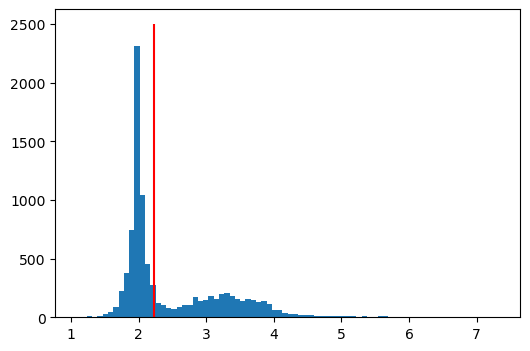

In [9]:
plt.rcParams["figure.figsize"] = (6,4)
plt.hist(absolute_ploidy, bins=80)
plt.vlines([ma], color='r', ymin=0, ymax=2500)
plt.savefig('ploidy_cutoff_selection.pdf')
plt.show()

In [10]:
absolute_ploidy_y.sum()/absolute_ploidy_y.count()

dichtomized_ploidy    0.388473
dtype: float64

In [11]:
tumor_order = list(tumor.join(absolute_ploidy).groupby('tumor').median().sort_values('ploidy', ascending=False).index)

In [12]:
coloring = (tumor.join(absolute_ploidy).groupby('tumor').median().sort_values('ploidy', ascending=False) > 2.5)

In [13]:
coloring['color'] = coloring['ploidy'].apply(lambda x: 'aquamarine' if x else 'whitesmoke')

In [14]:
my_colors = {x: 'pink' if x else 'grey' for x in df['coloring']}

NameError: name 'df' is not defined

/var/folders/j8/df8v0y1j16ng5mlcnmr38r0r0000gp/T/ipykernel_59370/594870090.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tumor_order = list(df.groupby('tumor').median().sort_values('ploidy', ascending=False).index)


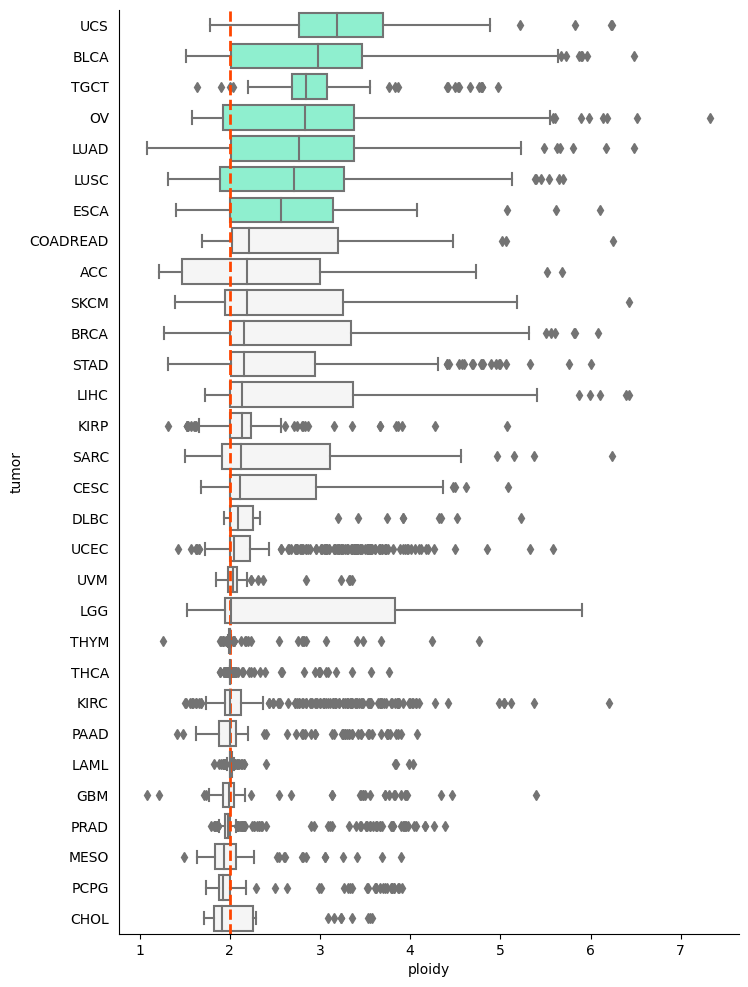

In [15]:
df = tumor.join(absolute_ploidy)
df['tumor'] = [x.upper() for x in list(df['tumor'].values)]
df['coloring'] = coloring['ploidy']
tumor_order = list(df.groupby('tumor').median().sort_values('ploidy', ascending=False).index)
plt.rcParams["figure.figsize"] = (8,12)
sns.boxplot(df, x='ploidy', y='tumor', order=tumor_order, color='w', palette=coloring['color'])
plt.axvline(2, color='orangered', linestyle='--', linewidth=2)
plt.tick_params(axis='y', which='both',  left=False, top=False, labelleft=True)
sns.despine()
plt.savefig('ploidy_by_tumortype.pdf')

## Select genes

In [16]:
pca = PCA(n_components=50)
pca.fit(rna.values)

PCA(n_components=50)

In [17]:
pca_loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), index=rna.columns)

In [18]:
genes_pca = abs(pca_loadings).sum(axis=1).nlargest(1000).index

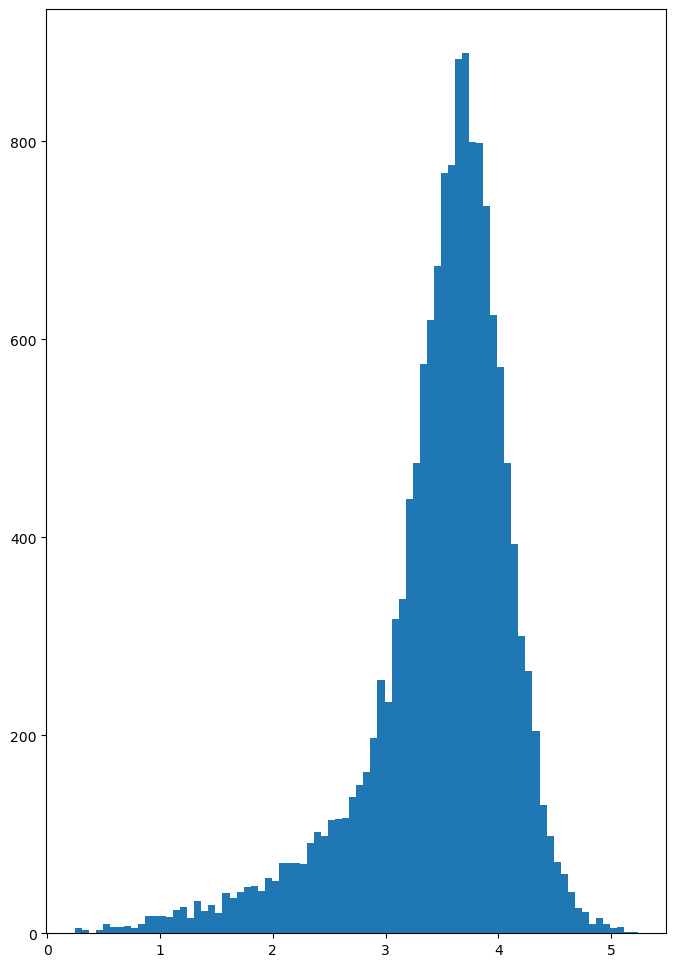

In [19]:
plt.hist(abs(pca_loadings).sum(axis=1), bins=80)
plt.show()

## Run pnet

In [20]:
import Pnet

In [21]:
genetic_data = {'rna': rna[genes_pca], 'cna': cna}

In [22]:
train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, absolute_ploidy_y)

Given 2 Input modalities
Found 9005 overlapping indicies
Initializing Train Dataset
Found 999 overlapping genes
generated input DataFrame of size (6304, 1998)
Initializing Test Dataset
Found 999 overlapping genes
generated input DataFrame of size (2701, 1998)


In [24]:
import ReactomeNetwork

In [25]:
reactome_network = ReactomeNetwork.ReactomeNetwork(train_dataset.get_genes())

Found 999 overlapping genes


In [26]:
model = Pnet.PNET_NN(hparams=
                     {'reactome_network':reactome_network, 'nbr_gene_inputs':len(genetic_data), 'dropout':0.2,
                      'additional_dims':0, 'lr':1e-3, 'weight_decay':1}
                    )

In [27]:
train_loader, val_loader = pnet_loader.to_dataloader(train_dataset, test_dataset, 64)

In [30]:
import pytorch_lightning as pl

In [33]:
trainer = pl.Trainer(precision='bf16', accelerator=None, max_epochs=100, log_every_n_steps=50, 
                     enable_checkpointing=True)

trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader,)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type       | Params
------------------------------------------------
0 | layers           | ModuleList | 5.1 M 
1 | preds            | ModuleList | 2.2 K 
2 | input_layer      | Sequential | 4.0 M 
3 | first_gene_layer | Sequential | 1.5 M 
4 | drop1            | Dropout    | 0     
5 | attn             | Linear     | 6     
------------------------------------------------
5.3 M     Trainable params
5.3 M     Non-trainable params
10.6 M    Total params
42.323    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

RuntimeError: expected scalar type BFloat16 but found Float

In [18]:
model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data,
                                                                         absolute_ploidy_y,
                                                                         verbose=True,
                                                                         early_stopping=False)

Given 2 Input modalities
Found 9005 overlapping indicies
Initializing Train Dataset
Found 999 overlapping genes
generated input DataFrame of size (6304, 1998)
Initializing Test Dataset
Found 999 overlapping genes
generated input DataFrame of size (2701, 1998)
Found 999 overlapping genes
Epoch 1 of 300
Train scores: (0.6786631687643564, 0.6005710659898477)
Test scores: (0.6407805082313399, 0.7693446871529064)
Epoch 2 of 300
Train scores: (0.5492561178158988, 0.8094860406091371)
Test scores: (0.5067217508010271, 0.8378378378378378)
Epoch 3 of 300
Train scores: (0.48582823824156357, 0.8153553299492385)
Test scores: (0.45661684990988444, 0.8441318030359126)
Epoch 4 of 300
Train scores: (0.4550272456280471, 0.8247144670050761)
Test scores: (0.4342218792381131, 0.8430211032950758)
Epoch 5 of 300
Train scores: (0.4412213163024883, 0.8274111675126904)
Test scores: (0.41859824848987137, 0.8515364679748242)
Epoch 6 of 300
Train scores: (0.4318506233583247, 0.8296319796954315)
Test scores: (0.410

Epoch 63 of 300
Train scores: (0.394927054643631, 0.8331218274111675)
Test scores: (0.35799863284625466, 0.8496853017400963)
exceeded delta
Epoch 64 of 300
Train scores: (0.4003437126651028, 0.836770304568528)
Test scores: (0.35670920867736317, 0.8559792669381711)
Epoch 65 of 300
Train scores: (0.3971464158919862, 0.838991116751269)
Test scores: (0.3585622128801229, 0.853387634209552)
exceeded delta
Epoch 66 of 300
Train scores: (0.4008724716714191, 0.8312182741116751)
Test scores: (0.3569560513501695, 0.8556090336912254)
Epoch 67 of 300
Train scores: (0.39887803097061697, 0.833756345177665)
Test scores: (0.3569197902764183, 0.8541281007034431)
Epoch 68 of 300
Train scores: (0.3933670484475073, 0.8356598984771574)
Test scores: (0.3566025444773646, 0.8500555349870418)
Epoch 69 of 300
Train scores: (0.39691910586381324, 0.8334390862944162)
Test scores: (0.3546554449971894, 0.8526471677156608)
Epoch 70 of 300
Train scores: (0.40124848348840236, 0.8356598984771574)
Test scores: (0.35809412

Epoch 123 of 300
Train scores: (0.3906535674170189, 0.8380393401015228)
Test scores: (0.35718257865919883, 0.8515364679748242)
exceeded delta
Epoch 124 of 300
Train scores: (0.39674705327464843, 0.8364530456852792)
Test scores: (0.36190229784511097, 0.853387634209552)
exceeded delta
Epoch 125 of 300
Train scores: (0.40006089376919163, 0.8351840101522843)
Test scores: (0.35925308680896273, 0.8541281007034431)
exceeded delta
Epoch 126 of 300
Train scores: (0.3944034000036075, 0.8380393401015228)
Test scores: (0.3582018298248325, 0.8504257682339874)
exceeded delta
Epoch 127 of 300
Train scores: (0.3916541419658564, 0.8383565989847716)
Test scores: (0.3568124738458085, 0.8537578674564976)
exceeded delta
Epoch 128 of 300
Train scores: (0.3937472271435152, 0.8345494923857868)
Test scores: (0.3573016220885089, 0.8541281007034431)
exceeded delta
Epoch 129 of 300
Train scores: (0.39178075418254443, 0.8359771573604061)
Test scores: (0.35777281249553705, 0.8570899666790077)
exceeded delta
Epoch 1

Epoch 182 of 300
Train scores: (0.3947031867080534, 0.8331218274111675)
Test scores: (0.3603629056103624, 0.8544983339503888)
exceeded delta
Epoch 183 of 300
Train scores: (0.3898402597698463, 0.8348667512690355)
Test scores: (0.35248989663447156, 0.8585708996667901)
Epoch 184 of 300
Train scores: (0.3909161582513509, 0.8299492385786802)
Test scores: (0.35443920261195216, 0.8570899666790077)
exceeded delta
Epoch 185 of 300
Train scores: (0.3838202929133691, 0.8407360406091371)
Test scores: (0.3545298590478258, 0.8544983339503888)
exceeded delta
Epoch 186 of 300
Train scores: (0.38677336328525835, 0.8427982233502538)
Test scores: (0.3528738586781688, 0.8611625323954091)
Epoch 187 of 300
Train scores: (0.39017751737294465, 0.8378807106598984)
Test scores: (0.3581396526250518, 0.8544983339503888)
exceeded delta
Epoch 188 of 300
Train scores: (0.3955641143818192, 0.8359771573604061)
Test scores: (0.35252909429070683, 0.8589411329137356)
Epoch 189 of 300
Train scores: (0.3894179280336738, 0

Epoch 241 of 300
Train scores: (0.3863579155829957, 0.8386738578680203)
Test scores: (0.3578428037517029, 0.853387634209552)
exceeded delta
Epoch 242 of 300
Train scores: (0.38885544081629836, 0.8401015228426396)
Test scores: (0.359181194206557, 0.8541281007034431)
exceeded delta
Epoch 243 of 300
Train scores: (0.38118089606919264, 0.840260152284264)
Test scores: (0.35408232345355084, 0.857830433172899)
exceeded delta
Epoch 244 of 300
Train scores: (0.38298643179956426, 0.8413705583756346)
Test scores: (0.3557950300183485, 0.8519067012217697)
exceeded delta
Epoch 245 of 300
Train scores: (0.3940641668242246, 0.8313769035532995)
Test scores: (0.3534585889380581, 0.8585708996667901)
exceeded delta
Epoch 246 of 300
Train scores: (0.39203178791830384, 0.8359771573604061)
Test scores: (0.35794210169148505, 0.8556090336912254)
exceeded delta
Epoch 247 of 300
Train scores: (0.39150593229356756, 0.8421637055837563)
Test scores: (0.3566013123979396, 0.8511662347278786)
exceeded delta
Epoch 248 

Epoch 300 of 300
Train scores: (0.38884432712182176, 0.8407360406091371)
Test scores: (0.3578381819091255, 0.8548685671973343)
exceeded delta


In [19]:
x_train = train_dataset.input_df.astype(float).values
additional_train = train_dataset.additional_data.astype(float).values
y_train = train_dataset.target.astype(float).values.reshape(-1)
x_test = test_dataset.input_df.astype(float).values
additional_test = test_dataset.additional_data.astype(float).values
y_test = test_dataset.target.astype(float).values.reshape(-1)

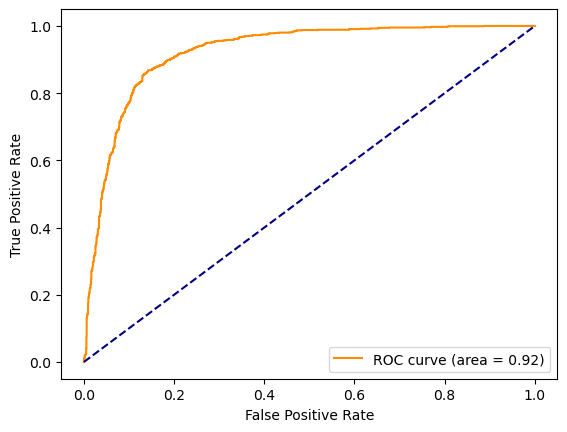

In [20]:
pred = model(torch.tensor(x_test, dtype=torch.float),
                          torch.tensor(additional_test, dtype=torch.float)
            )
y_pred_proba = pred.detach().numpy().squeeze()
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
test_auc = metrics.roc_auc_score(y_test, pred.detach().numpy().squeeze())
#create ROC curve
plt.plot(fpr,tpr, color="darkorange", label="ROC curve (area = %0.2f)" % test_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.legend(loc="lower right")
plt.savefig('PNET_ploidy_ROC_curve.pdf')
plt.show()

In [21]:
gene_importances, additional_importances = model.deepLIFT(test_dataset)

/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [25]:
abs(gene_importances.mean()).nlargest(20)

EFCAB1_cna     0.020892
CCDC96_cna     0.016935
MEF2C_cna      0.013162
TCEB3          0.012955
IK             0.012314
FAM156A_cna    0.011955
WDR55          0.011676
YIPF5_cna      0.010679
RHBDD2_cna     0.010557
GKAP1          0.010189
KLHL14_cna     0.010088
TEKT4_cna      0.009610
JTB            0.009225
DNAH6          0.009160
ANXA8          0.008809
SPEF1_cna      0.008644
PEX11B_cna     0.008297
ZNF366_cna     0.007982
CFL2_cna       0.007716
SIRPG_cna      0.007629
dtype: float32

In [28]:
gene_order = gene_importances.mean().sort_values(ascending=False).index
gene_order

Index(['EFCAB1_cna', 'CCDC96_cna', 'MEF2C_cna', 'FAM156A_cna', 'YIPF5_cna',
       'RHBDD2_cna', 'GKAP1', 'KLHL14_cna', 'TEKT4_cna', 'JTB',
       ...
       'DALRD3', 'PPP1R8', 'APOL3', 'UBR7', 'APOL3_cna', 'KANK2', 'GIGYF1_cna',
       'WDR55', 'IK', 'TCEB3'],
      dtype='object', length=1998)

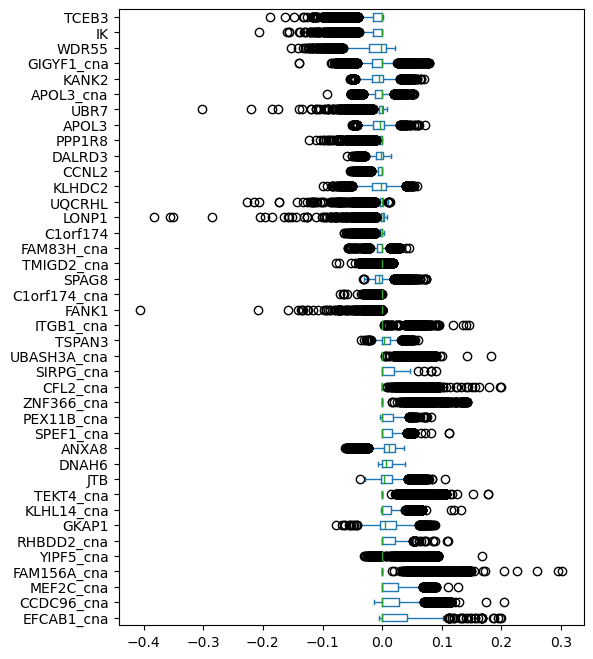

In [29]:
plt.rcParams["figure.figsize"] = (6,8)
gene_importances[list(gene_order[:20]) + list(gene_order[-20:])].plot(kind='box', vert=False)
plt.savefig('genes_ploidy.pdf')
plt.show()

In [30]:
pathway_importances = model.layerwise_importance(test_dataset)

In [32]:
for l in pathway_importances:
    print(l.nlargest(5))

Selenocysteine synthesis                                         9.044931
COPI-mediated anterograde transport                              4.567622
PPARA activates gene expression                                  4.349679
Major pathway of rRNA processing in the nucleolus and cytosol    4.314996
Cargo recognition for clathrin-mediated endocytosis              3.407286
dtype: float32
Phase 0 - rapid depolarisation                                               13.461351
Selenoamino acid metabolism                                                   9.041038
Nonsense Mediated Decay (NMD) enhanced by the Exon Junction Complex (EJC)     8.642056
Regulation of insulin secretion                                               7.450041
Transferrin endocytosis and recycling                                         6.371079
dtype: float32
Factors involved in megakaryocyte development and platelet production    20.947962
Smooth Muscle Contraction                                                20.253508

In [289]:
pred = model(torch.tensor(x_test, dtype=torch.float),
                          torch.tensor(additional_test, dtype=torch.float)
            )

In [298]:
pred_ = pd.DataFrame(pred.detach().numpy(), index=test_dataset.input_df.index, columns=['prediction'])

In [299]:
pred_.join(tumor)

,prediction,tumor
TCGA-41-2571-01,0.030634,gbm
TCGA-GN-A265-06,0.551981,skcm
TCGA-BP-4970-01,0.050676,kirc
TCGA-OL-A5RZ-01,0.761787,brca
TCGA-DJ-A2Q3-01,0.025374,thca
...,...,...
TCGA-2G-AAFL-01,0.225019,tgct
TCGA-B5-A3F9-01,0.151234,ucec
TCGA-AL-7173-01,0.036936,kirp
TCGA-DH-A66G-01,0.431044,lgg


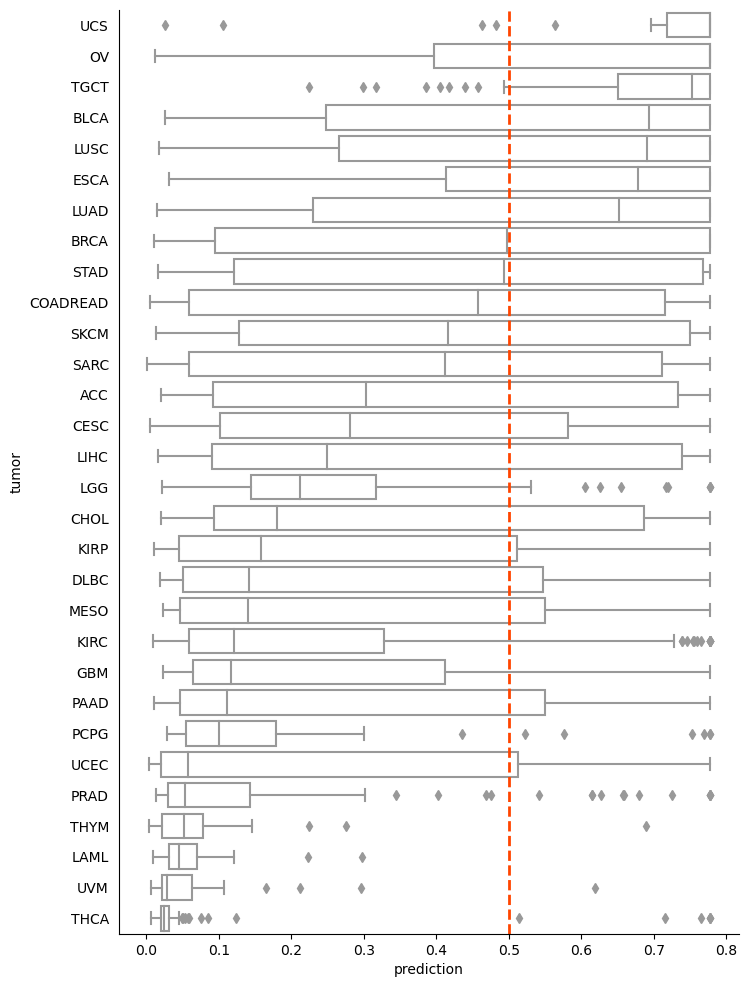

In [300]:
df = pred_.join(tumor)
df['tumor'] = [x.upper() for x in list(df['tumor'].values)]
tumor_order = list(df.groupby('tumor').median().sort_values('prediction', ascending=False).index)
plt.rcParams["figure.figsize"] = (8,12)
sns.boxplot(df, x='prediction', y='tumor', order=tumor_order, color='w')
plt.axvline(0.5, color='orangered', linestyle='--', linewidth=2)
plt.tick_params(axis='y', which='both',  left=False, top=False, labelleft=True)
sns.despine()
#plt.savefig('ploidy_by_tumortype.pdf')

<AxesSubplot: xlabel='dichtomized_ploidy', ylabel='misclass'>

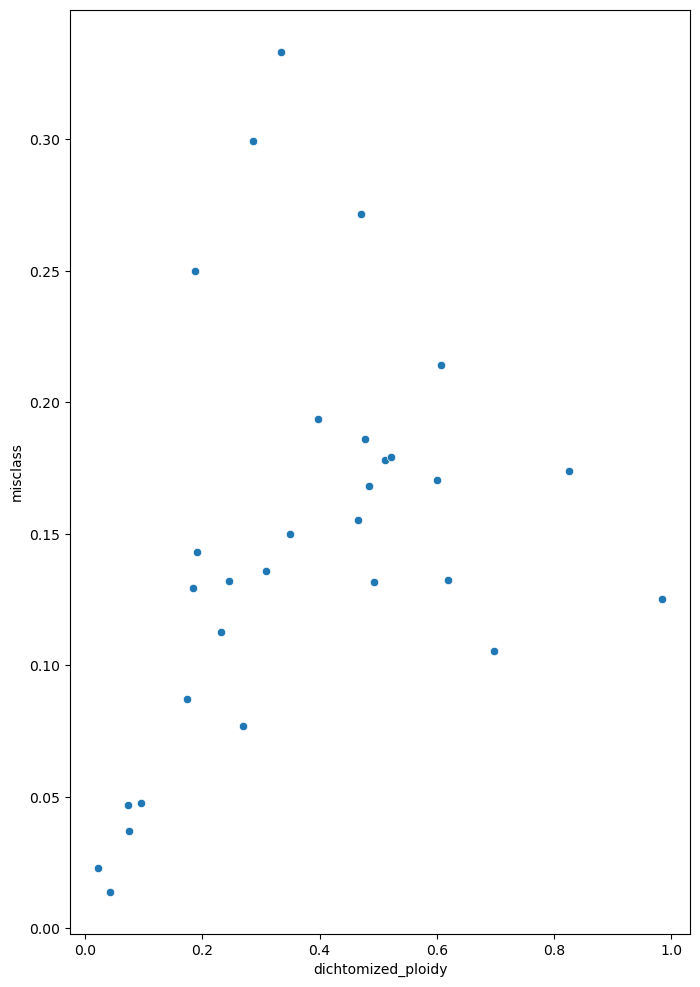

In [309]:
missclass_df = pred_.join(tumor).join(test_dataset.target)
missclass_df['misclass'] = missclass_df.apply(lambda x: 1-int(round(x['prediction'])==x['dichtomized_ploidy']), axis=1)
sns.scatterplot(missclass_df.groupby('tumor').mean(), x='dichtomized_ploidy', y='misclass')

## Multiple runs

In [51]:
def fold_run(x, y, n):
    aucs = []
    most_imp_genes = []
    for r in range(n):
        print('run: {}'.format(r))
        model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(x,
                                                                             y,
                                                                             verbose=False,
                                                                             early_stopping=True)

        x_train = train_dataset.input_df.astype(float).values
        additional_train = train_dataset.additional_data.astype(float).values
        y_train = train_dataset.target.astype(float).values.reshape(-1)
        x_test = test_dataset.input_df.astype(float).values
        additional_test = test_dataset.additional_data.astype(float).values
        y_test = test_dataset.target.astype(float).values.reshape(-1)

        pred = model(torch.tensor(x_test, dtype=torch.float),
                                  torch.tensor(additional_test, dtype=torch.float)
                    )
        y_pred_proba = pred.detach().numpy().squeeze()
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
        test_auc = metrics.roc_auc_score(y_test, pred.detach().numpy().squeeze())

        aucs.append(test_auc)

        gene_importances, additional_importances = model.deepLIFT(test_dataset)
        most_imp_genes.append(gene_importances.sum())
    return aucs, most_imp_genes

In [52]:
def fold_run_rf(x, y, n):
    aucs = []
    most_imp_genes = []
    for r in range(n):
        print('run: {}'.format(r))
        train_dataset, test_dataset = pnet_loader.generate_train_test(x, y, None, None, 0.3, None)
        clf = RandomForestClassifier()
        clf.fit(train_dataset.input_df.values, train_dataset.target.values.reshape(-1))
        
        x_train = train_dataset.input_df.astype(float).values
        additional_train = train_dataset.additional_data.astype(float).values
        y_train = train_dataset.target.astype(float).values.reshape(-1)
        x_test = test_dataset.input_df.astype(float).values
        additional_test = test_dataset.additional_data.astype(float).values
        y_test = test_dataset.target.astype(float).values.reshape(-1)

        y_pred_proba = clf.predict_proba(x_test)
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba[:,1])
        test_auc = metrics.roc_auc_score(y_test, y_pred_proba[:,1])

        aucs.append(test_auc)

        gene_importances = clf.feature_importances_
        most_imp_genes.append(pd.DataFrame(clf.feature_importances_, index=test_dataset.input_df.columns))
    return aucs, most_imp_genes

In [53]:
ploidy_absolut_auc, ploidy_absolut_genes = fold_run(genetic_data, absolute_ploidy_y, 10)
ploidy_absolut_auc_rf, ploidy_absolut_genes_rf = fold_run_rf(genetic_data, absolute_ploidy_y, 10)

run: 0
Given 2 Input modalities
Found 9005 overlapping indicies
Initializing Train Dataset
Found 999 overlapping genes
generated input DataFrame of size (6304, 1998)
Initializing Test Dataset
Found 999 overlapping genes
generated input DataFrame of size (2701, 1998)
Found 999 overlapping genes
Hit early stopping criteria


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 1
Given 2 Input modalities
Found 9005 overlapping indicies
Initializing Train Dataset
Found 999 overlapping genes
generated input DataFrame of size (6304, 1998)
Initializing Test Dataset
Found 999 overlapping genes
generated input DataFrame of size (2701, 1998)
Found 999 overlapping genes
Hit early stopping criteria


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 2
Given 2 Input modalities
Found 9005 overlapping indicies
Initializing Train Dataset
Found 999 overlapping genes
generated input DataFrame of size (6304, 1998)
Initializing Test Dataset
Found 999 overlapping genes
generated input DataFrame of size (2701, 1998)
Found 999 overlapping genes
Hit early stopping criteria


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 3
Given 2 Input modalities
Found 9005 overlapping indicies
Initializing Train Dataset
Found 999 overlapping genes
generated input DataFrame of size (6304, 1998)
Initializing Test Dataset
Found 999 overlapping genes
generated input DataFrame of size (2701, 1998)
Found 999 overlapping genes
Hit early stopping criteria


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 4
Given 2 Input modalities
Found 9005 overlapping indicies
Initializing Train Dataset
Found 999 overlapping genes
generated input DataFrame of size (6304, 1998)
Initializing Test Dataset
Found 999 overlapping genes
generated input DataFrame of size (2701, 1998)
Found 999 overlapping genes
Hit early stopping criteria


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 5
Given 2 Input modalities
Found 9005 overlapping indicies
Initializing Train Dataset
Found 999 overlapping genes
generated input DataFrame of size (6304, 1998)
Initializing Test Dataset
Found 999 overlapping genes
generated input DataFrame of size (2701, 1998)
Found 999 overlapping genes
Hit early stopping criteria


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 6
Given 2 Input modalities
Found 9005 overlapping indicies
Initializing Train Dataset
Found 999 overlapping genes
generated input DataFrame of size (6304, 1998)
Initializing Test Dataset
Found 999 overlapping genes
generated input DataFrame of size (2701, 1998)
Found 999 overlapping genes
Hit early stopping criteria


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 7
Given 2 Input modalities
Found 9005 overlapping indicies
Initializing Train Dataset
Found 999 overlapping genes
generated input DataFrame of size (6304, 1998)
Initializing Test Dataset
Found 999 overlapping genes
generated input DataFrame of size (2701, 1998)
Found 999 overlapping genes
Hit early stopping criteria


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 8
Given 2 Input modalities
Found 9005 overlapping indicies
Initializing Train Dataset
Found 999 overlapping genes
generated input DataFrame of size (6304, 1998)
Initializing Test Dataset
Found 999 overlapping genes
generated input DataFrame of size (2701, 1998)
Found 999 overlapping genes
Hit early stopping criteria


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 9
Given 2 Input modalities
Found 9005 overlapping indicies
Initializing Train Dataset
Found 999 overlapping genes
generated input DataFrame of size (6304, 1998)
Initializing Test Dataset
Found 999 overlapping genes
generated input DataFrame of size (2701, 1998)
Found 999 overlapping genes
Hit early stopping criteria


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 0
Given 2 Input modalities
Found 9005 overlapping indicies
Initializing Train Dataset
Found 999 overlapping genes
generated input DataFrame of size (6304, 1998)
Initializing Test Dataset
Found 999 overlapping genes
generated input DataFrame of size (2701, 1998)
run: 1
Given 2 Input modalities
Found 9005 overlapping indicies
Initializing Train Dataset
Found 999 overlapping genes
generated input DataFrame of size (6304, 1998)
Initializing Test Dataset
Found 999 overlapping genes
generated input DataFrame of size (2701, 1998)
run: 2
Given 2 Input modalities
Found 9005 overlapping indicies
Initializing Train Dataset
Found 999 overlapping genes
generated input DataFrame of size (6304, 1998)
Initializing Test Dataset
Found 999 overlapping genes
generated input DataFrame of size (2701, 1998)
run: 3
Given 2 Input modalities
Found 9005 overlapping indicies
Initializing Train Dataset
Found 999 overlapping genes
generated input DataFrame of size (6304, 1998)
Initializing Test Dataset
Found 9

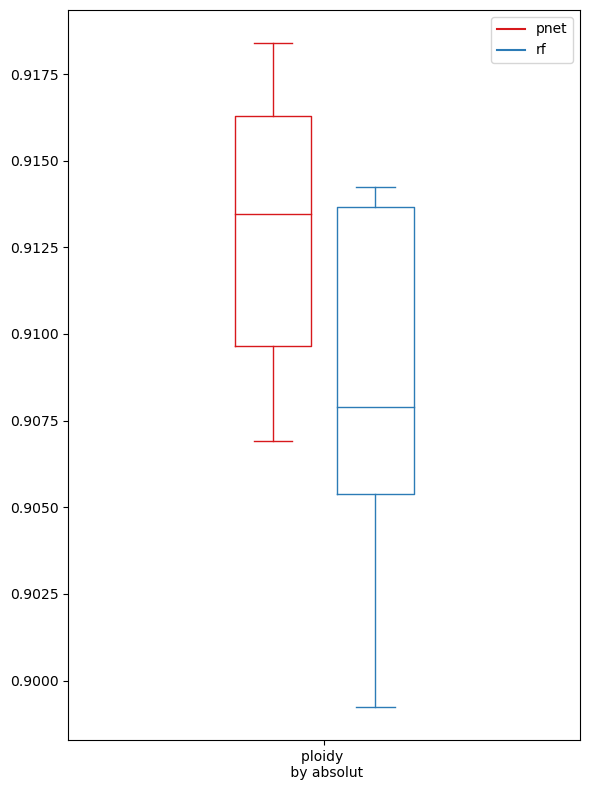

In [54]:
data_pnet = [ploidy_absolut_auc]
data_rf = [ploidy_absolut_auc_rf]

ticks = ['ploidy \n by absolut']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    
    
bpl = plt.boxplot(data_pnet, positions=np.array(range(len(data_pnet)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(data_rf, positions=np.array(range(len(data_pnet)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

plt.plot([], c='#D7191C', label='pnet')
plt.plot([], c='#2C7BB6', label='rf')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.tight_layout()
plt.savefig('absolute_ploidy_auc_pnet_vs_rf.pdf')

In [55]:
ploidy_absolut_genes

[MRS2          0.000000e+00
 CDX2          0.000000e+00
 RIMS3         7.667880e-04
 SLC12A5       0.000000e+00
 HLA-DOB       2.899540e-01
                   ...     
 MVP_cna       8.939170e-13
 ODF2L_cna     0.000000e+00
 NOC2L_cna     0.000000e+00
 RPS27A_cna    1.062717e+01
 NEXN_cna      0.000000e+00
 Length: 1998, dtype: float32,
 MRS2          0.000000e+00
 CDX2          1.712549e-01
 RIMS3         2.468657e-01
 SLC12A5       0.000000e+00
 HLA-DOB       0.000000e+00
                   ...     
 MVP_cna       1.228486e-23
 ODF2L_cna     2.382133e-03
 NOC2L_cna     0.000000e+00
 RPS27A_cna    2.814907e+01
 NEXN_cna     -3.337596e-05
 Length: 1998, dtype: float32,
 MRS2          0.000000e+00
 CDX2          0.000000e+00
 RIMS3        -4.296706e-01
 SLC12A5       0.000000e+00
 HLA-DOB       0.000000e+00
                   ...     
 MVP_cna       0.000000e+00
 ODF2L_cna    -2.417002e-08
 NOC2L_cna     0.000000e+00
 RPS27A_cna    9.716559e+00
 NEXN_cna      0.000000e+00
 Length: 1998,

In [56]:
ploidy_absolut_genes_rf

[                   0
 MRS2        0.000418
 CDX2        0.000348
 RIMS3       0.000493
 SLC12A5     0.000482
 HLA-DOB     0.000560
 ...              ...
 MVP_cna     0.000403
 ODF2L_cna   0.000089
 NOC2L_cna   0.000265
 RPS27A_cna  0.001382
 NEXN_cna    0.000175
 
 [1998 rows x 1 columns],
                    0
 MRS2        0.000503
 CDX2        0.000293
 RIMS3       0.000474
 SLC12A5     0.000488
 HLA-DOB     0.000556
 ...              ...
 MVP_cna     0.000170
 ODF2L_cna   0.000213
 NOC2L_cna   0.000071
 RPS27A_cna  0.001919
 NEXN_cna    0.000073
 
 [1998 rows x 1 columns],
                    0
 MRS2        0.000688
 CDX2        0.000265
 RIMS3       0.000437
 SLC12A5     0.000397
 HLA-DOB     0.000458
 ...              ...
 MVP_cna     0.000138
 ODF2L_cna   0.000105
 NOC2L_cna   0.000098
 RPS27A_cna  0.002273
 NEXN_cna    0.000215
 
 [1998 rows x 1 columns],
                    0
 MRS2        0.000539
 CDX2        0.000236
 RIMS3       0.000376
 SLC12A5     0.000383
 HLA-DOB     0

In [57]:
gene_order = pd.DataFrame(ploidy_absolut_genes).mean().sort_values(ascending=False).index
df_sum = pd.DataFrame(ploidy_absolut_genes)

In [58]:
gene_order_rf = pd.DataFrame([x[0] for x in ploidy_absolut_genes_rf]).mean().sort_values(ascending=False).index
df_sum_rf = pd.DataFrame([x[0] for x in ploidy_absolut_genes_rf])

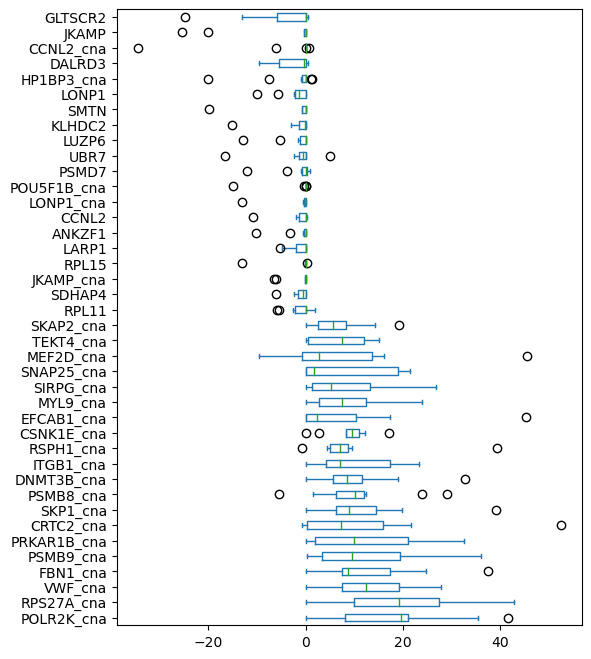

In [59]:
plt.rcParams["figure.figsize"] = (6,8)
df_sum[list(gene_order[:20]) + list(gene_order[-20:])].plot(kind='box', vert=False)
plt.savefig('Ploidy_important_genes.pdf')
plt.show()

In [120]:
def check_annotate(x, y):
    if y > 1e-3/(x)**1.9 + 1e-3:
        return True
    else:
        return False

In [124]:
import scipy.stats as ss

In [123]:
comb_df['pnet_rank'] = ss.rankdata(comb_df['pnet_imp'])
comb_df['rf_rank'] = ss.rankdata(comb_df['rf_imp'])

,pnet_imp,rf_imp,annotate
MRS2,2.668602e-01,0.000512,False
CDX2,1.712549e-02,0.000292,False
RIMS3,5.425925e-02,0.000451,False
SLC12A5,8.790766e-04,0.000465,False
HLA-DOB,3.412940e-02,0.000534,False
...,...,...,...
MVP_cna,9.063299e-01,0.000310,False
ODF2L_cna,6.749939e-01,0.000158,False
NOC2L_cna,1.484890e-37,0.000117,False
RPS27A_cna,1.832629e+01,0.001700,True


In [136]:
comb_df = pd.DataFrame([df_sum.mean(), df_sum_rf.mean()]).T
comb_df.columns = ['pnet_imp', 'rf_imp']
comb_df['pnet_rank'] = len(comb_df['pnet_imp']) - ss.rankdata(abs(comb_df['pnet_imp']))
comb_df['rf_rank'] = len(comb_df['rf_imp']) - ss.rankdata(abs(comb_df['rf_imp']))
comb_df['annotate'] = comb_df.apply(lambda x: x['pnet_rank'] + x['rf_rank'] < 100, axis=1)

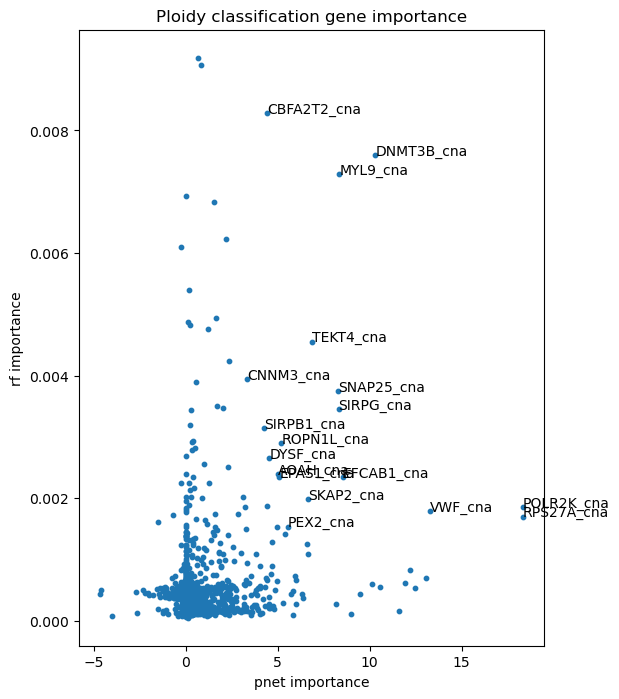

In [137]:
fig, ax = plt.subplots()

ax.scatter(comb_df['pnet_imp'], comb_df['rf_imp'], s=10)

for i in range(len(comb_df)):
    if comb_df.iloc[i]['annotate']:
        ax.annotate(comb_df.iloc[i].name, (comb_df.iloc[i]['pnet_imp'], comb_df.iloc[i]['rf_imp']))

plt.ylabel('rf importance')
plt.xlabel('pnet importance')
plt.title('Ploidy classification gene importance')
plt.savefig('important_genes_ploidy_scatter.pdf')
plt.show()

In [138]:
import gseapy as gp

In [175]:
def prerank_gsea(gene_importances, gene_list):
    gene_sets='../data/reactome/ReactomePathways.gmt'
    gene_importance_scores = pd.DataFrame(index=gene_list)
    gene_importance_scores['1'] = gene_importances.values.reshape((2,-1)).sum(axis=0)
        
    pre_res = gp.prerank(rnk=gene_importance_scores,
                         gene_sets = gene_sets,
                         threads=8,
                         min_size=5,
                         max_size=1000,
                         permutation_num=1000,
                         outdir='../prerank_gsea',
                         seed=6,
                         verbose=True
                        )
    return pre_res

In [176]:
pre_res_rf = prerank_gsea(comb_df['rf_imp'], list(comb_df.iloc[:int(comb_df.shape[0]/2)].index))

2023-03-07 14:24:29,461 [INFO] Parsing data files for GSEA.............................
2023-03-07 14:24:29,504 [INFO] 2077 gene_sets have been filtered out when max_size=1000 and min_size=5
2023-03-07 14:24:29,504 [INFO] 0407 gene_sets used for further statistical testing.....
2023-03-07 14:24:29,504 [INFO] Start to run GSEA...Might take a while..................
2023-03-07 14:24:30,040 [INFO] Start to generate gseapy reports, and produce figures...
2023-03-07 14:24:30,040 [INFO] Congratulations. GSEApy runs successfully................



In [177]:
top_hits_rf = list(pre_res_rf.res2d.sort_values('NOM p-val').head(15)['Term'])

In [178]:
top_hits_rf

['Post-translational protein modification',
 'Epigenetic regulation of gene expression',
 'Protein ubiquitination',
 'DNA Damage Recognition in GG-NER',
 'Metabolism of nucleotides',
 'Formation of TC-NER Pre-Incision Complex',
 'Nucleotide Excision Repair',
 'Signaling by FGFR2',
 'N-glycan trimming in the ER and Calnexin/Calreticulin cycle',
 'Nef-mediates down modulation of cell surface receptors by recruiting them to clathrin adapters',
 'Positive epigenetic regulation of rRNA expression',
 'DNA Repair',
 'RHO GTPases activate PKNs',
 'Gene expression (Transcription)',
 'Asparagine N-linked glycosylation']

In [172]:
pre_res_pnet = prerank_gsea(comb_df['pnet_imp'], list(comb_df.iloc[:int(comb_df.shape[0]/2)].index))

2023-03-07 14:17:18,189 [WARNING] Duplicated values found in preranked stats: 8.71% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-03-07 14:17:18,190 [INFO] Parsing data files for GSEA.............................
2023-03-07 14:17:18,224 [INFO] 2077 gene_sets have been filtered out when max_size=1000 and min_size=5
2023-03-07 14:17:18,225 [INFO] 0407 gene_sets used for further statistical testing.....
2023-03-07 14:17:18,225 [INFO] Start to run GSEA...Might take a while..................
2023-03-07 14:17:24,451 [INFO] Start to generate gseapy reports, and produce figures...
2023-03-07 14:17:24,451 [INFO] Congratulations. GSEApy runs successfully................



In [173]:
top_hits_pnet = list(pre_res_pnet.res2d.sort_values('NOM p-val').head(15)['Term'])

In [174]:
top_hits_pnet

['TCF dependent signaling in response to WNT',
 'Disease',
 'Post-translational protein modification',
 'Signal Transduction',
 'Diseases of signal transduction by growth factor receptors and second messengers',
 'Hemostasis',
 'Cell Cycle',
 'Negative regulation of NOTCH4 signaling',
 'Downstream TCR signaling',
 'Activation of NF-kappaB in B cells',
 'Signaling by WNT',
 'Metabolism of proteins',
 'Mitotic Anaphase',
 'Mitotic Metaphase and Anaphase',
 'PCP/CE pathway']